Every salesman has a load constraint and the load has to be delivered to the destination. Every salesman can have multiple routes. The cost for one salesman is set to 0, every other salesman has a higher cost, yielding to avoid using them.

There is one start location, one delivery point, and one final destination, which is the start location (e.g., garbage collecting company). 

Certain locations have a higher priority, i.e., they ought to be in the solution. This is being implemented by increasing the objective if they are not in the solution. One could not allow solutions where a location with high priority is missing, but there could be settings where it is not possible that all locations with high priority are in the solution.


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import itertools


### Initialize the problem

In [40]:
numPoints = 25

# Generate random locations
X = []
Y = []

for i in range(numPoints):
    X.append(random.uniform(0,100))
    Y.append(random.uniform(0,100))
    

In [41]:
# Locations in a dataframe
df = pd.DataFrame()
df['ID'] = list(np.arange(1,numPoints+1))
df['X'] = X
df['Y'] = Y

# Put locations in a list
locations = list(df['ID'])


In [42]:
# Distance matrix
distance_matrix = []

for i in range(df.shape[0]):
    row = []
    
    for j in range(df.shape[0]):
        distance = np.sqrt((df['X'].iloc[i] - df['X'].iloc[j])**2 + (df['Y'].iloc[i] - df['Y'].iloc[j])**2)
        row.append(distance)
        
    distance_matrix.append(row)


In [43]:
# Color dictionary to plot the solution
numbers = []
colors = []

for i in range(len(list(mcolors.CSS4_COLORS))):
    numbers.append(i)
 
# for bigger problems
colors = list(mcolors.CSS4_COLORS)
# for smaller problems
colors = list(mcolors.BASE_COLORS)

# Convert lists to dictionary
color_dict = {}
for key in numbers:
    for value in colors:
        color_dict[key] = value
        colors.remove(value)
        break


### Problem Setup

In [44]:
# number of salesmen
SALESMEN = 1
SALESMEN_ROUTES = SALESMEN*2 #intermediary routes (from landfill to landfill)
SALESMEN_COST_HOME = 0 #route from start to delivery
SALESMEN_COST_INTER = 5000 #route from delivery to delivery
SALESMEN_COST_RETURN = 50000 #route from start to start (which is the finish)
SALESMEN_COST_ADDITIONAL = 100000 #cost for a new salesman
MAX_LOAD = 15
MISSING_LOCATION = 1000 #cost for locations that are not being inserted into the solution
DISTANCE_MAX = 3000 #maximum distance per salesman
 
locations_copy = copy.deepcopy(locations)

# routes for the salesmen
res = []
LOAD = [0] * (SALESMEN_ROUTES+SALESMEN)

# Final route may not contain pickup locations
for i in range(SALESMEN):
    LOAD.append(MAX_LOAD)

# Get a start location
start_location = random.sample(locations_copy, k=1)[0]
locations_copy.remove(start_location)
unused_locations = copy.deepcopy(locations)
unused_locations.remove(start_location)

# Landfill location (delivery)
LANDFILL = random.sample(locations_copy, k=1)[0]
locations_copy.remove(LANDFILL)
unused_locations.remove(LANDFILL)

for i in range(SALESMEN):
    res.append([start_location,LANDFILL])

for i in range(SALESMEN_ROUTES):
    res.append([LANDFILL,LANDFILL])

for i in range(SALESMEN):
    res.append([LANDFILL,start_location])
    
# Total distance
distance = [0] * (SALESMEN_ROUTES+2*SALESMEN)


In [45]:
# For plotting
names = []

for i in range(df.shape[0]):
    if df['ID'].iloc[i] == start_location:
        names.append('Start')
    elif df['ID'].iloc[i] == LANDFILL:
        names.append('Landfill')
    else:
        names.append(i+1)

df['NAME'] = names


In [46]:
# Add priority to the locations (higher priority means locations must be in solution)
priority = []

for i in range(df.shape[0]):
    priority.append(random.choices(population=[1,5], weights=[0.8,0.2], k=1)[0])
    
df['PRIORITY'] = priority
        

In [47]:
# Total distance per salesman
for i in range(len(res)):
    for j in range(len(res[i])-1):
        distance[i] += distance_matrix[res[i][j]-1][res[i][j+1]-1]
        
total_distance = [0] * SALESMEN

for i in range(len(res)):
    for j in range(SALESMEN):
        if i % SALESMEN == j:
            total_distance[i%(j+1)] += distance[i]
    

In [48]:
# Create random intial route
for i in range(len(locations_copy)):    
    
    res_interim = copy.deepcopy(res)
    total_distance_interim = [0] * (SALESMEN_ROUTES+2*SALESMEN)

    # In case there are more locations than available total space
    try:
        # Route to insert (a new location can only be inserted if the load is below the max threshold)
        insertion = random.sample(list(np.where(np.array(LOAD) < MAX_LOAD)[0]), k=1)[0]

        # Select a random location to insert
        random_location = random.sample(locations_copy, k=1)[0]
        locations_copy.remove(random_location)

        # Select a random spot to insert
        random_spot = random.sample(range(1,len(res_interim[insertion])),k=1)[0]
        res_interim[insertion].insert(random_spot,random_location)

        for k in range(len(res_interim)):
            for j in range(len(res_interim[k])-1):
                total_distance_interim[k] += distance_matrix[res_interim[k][j]-1][res_interim[k][j+1]-1]

        total_distance_interim_sum = [0] * SALESMEN

        for k in range(len(res)):
            for j in range(SALESMEN):
                if k % SALESMEN == j:
                    total_distance_interim_sum[k%(j+1)] += total_distance_interim[k]
                    
        if all(x <= DISTANCE_MAX for x in total_distance_interim_sum):
            res = res_interim
            total_distance = total_distance_interim
            unused_locations.remove(random_location)
            LOAD[insertion] += 1

    except: ValueError


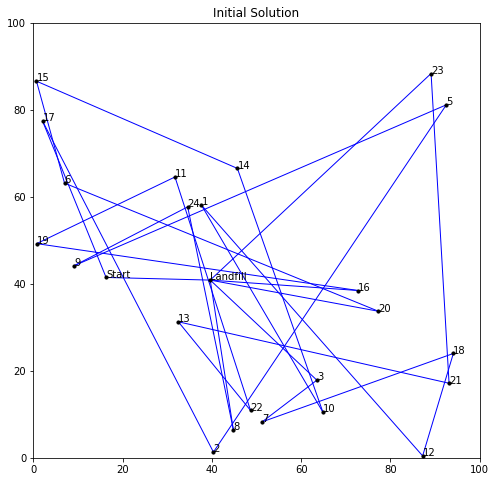

In [49]:
# Initial result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))
    
for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k%SALESMEN], linewidth=1)
            
plt.title('Initial Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


### Solving the problem

In [50]:
# Locations that can be removed from the current solution and reinserted
locations_copy = copy.deepcopy(locations)
locations_copy.remove(start_location)
locations_copy.remove(LANDFILL)


In [51]:
# Develeopment of the solution
history = []

# shortest route
shortest_route = [0]*(2*SALESMEN+SALESMEN_ROUTES)
shortest_distance = [0]*(2*SALESMEN+SALESMEN_ROUTES)

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix[res[i][j]-1][res[i][j+1]-1]
        shortest_distance[i] += distance_matrix[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        if res[i][0] == start_location:
            shortest_route[i] += SALESMEN_COST_HOME
        elif res[i][-1] == start_location:
            shortest_route[i] += SALESMEN_COST_RETURN
        else:
            shortest_route[i] += SALESMEN_COST_INTER
            
missing_priority = 0

for loc in unused_locations:
    missing_priority += priority[loc-1]
    
# Cost for additional salesman    
COST = []
for i in range(len(res)):
    if i%SALESMEN == 0:
        COST.append(0)
    else:
        # Vevery additional salesman has a higher cost, yielding their avoidance in the final solution
        COST.append(SALESMEN_COST_ADDITIONAL * (10**(i%SALESMEN)))

# Additional cost
cost_add = []

# every location in the route has a cost
for i in range(len(res)):
    cost_add.append((len(res[i])-2)*COST[i])
    
# every newly used route has a cost
for i in range(len(res)):
    if len(res[i]) > 2:
        cost_add[i] += COST[i]
    
# Objective
objective = sum(shortest_route) + MISSING_LOCATION * missing_priority + sum(cost_add)
history.append(objective)

print(res)
print('Lengths of the routes:', shortest_distance)
print('Objective initial solution:', objective)


[[4, 17, 2, 5, 9, 24, 8, 25], [25, 3, 7, 18, 12, 1, 10, 14, 15, 6, 20, 25], [25, 16, 19, 11, 22, 13, 21, 23, 25], [25, 4]]
Lengths of the routes: [426.24002798297687, 497.1452662617794, 425.03166973119676, 23.33414302920207]
Objective initial solution: 11371.751107005155


In [ ]:
# Initial solution
print(res)
print('Lengths of the routes:', shortest_distance)
print('Current best solution:', objective)
print()

for tries in range(1000000):    
    # maximum number of locations to remove
    max_removes = int(np.round(len(locations)/2))

    # make a copy of the current route
    res_interim = copy.deepcopy(res)    
    LOAD_interim = copy.deepcopy(LOAD)

    # locations to remove (at least 1)
    number = random.sample(range(1,max_removes), 1)[0]
    loc_remove = random.sample(locations_copy, number)

    # remove locations and loads from route
    for loc in (loc_remove):   
        for i in range(len(res_interim)):
            if loc in res_interim[i]:
                res_interim[i].remove(loc)
                LOAD_interim[i] -= 1

    try:

        # randomly insert locations into result
        for loc in (loc_remove):
            # Route to insert
            insertion = random.sample(list(np.where(np.array(LOAD_interim) < MAX_LOAD)[0]), k=1)[0]
            LOAD_interim[insertion] += 1

            insert_position = np.random.randint(1,len(res_interim[insertion]))
            res_interim[insertion].insert(insert_position, loc)

    except: ValueError

    current_route_interim = [0]*(2*SALESMEN+SALESMEN_ROUTES)
    current_distance_interim = [0]*(2*SALESMEN+SALESMEN_ROUTES)

    for i in range(len(res_interim)):
        for j in range(len(res_interim[i])-1):
            current_route_interim[i] += distance_matrix[res_interim[i][j]-1][res_interim[i][j+1]-1]
            current_distance_interim[i] += distance_matrix[res_interim[i][j]-1][res_interim[i][j+1]-1]
        if len(res_interim[i]) > 2:
            if res_interim[i][0] == start_location:
                current_route_interim[i] += SALESMEN_COST_HOME
            elif res_interim[i][-1] == start_location:
                current_route_interim[i] += SALESMEN_COST_RETURN
            else:
                current_route_interim[i] += SALESMEN_COST_INTER
                
    # Additional cost for a used route of an additional salesman
    cost_add = []

    for i in range(len(res_interim)):
        cost_add.append((len(res_interim[i])-2)*COST[i])
        
    # every newly used route has a cost
    for i in range(len(res_interim)):
        if len(res_interim[i]) > 2:
            cost_add[i] += COST[i]

    current_objective = sum(current_route_interim) + sum(cost_add)

    total_distance_interim_sum = [0] * SALESMEN

    for k in range(len(res_interim)):
        for j in range(SALESMEN):
            if k % SALESMEN == j:
                total_distance_interim_sum[k%(j+1)] += current_distance_interim[k]

     # Locations that are not part of the solution
    used_locations = []

    for i in range(len(res_interim)):
        for k in range(len(locations)):
            if locations[k] in res_interim[i]:
                used_locations.append(locations[k])

    unused_locations = [x for x in locations if x not in used_locations]

    # Sum of missing priorities
    missing_priority = 0
    for loc in unused_locations:
        missing_priority += priority[loc-1]

    if current_objective + MISSING_LOCATION * missing_priority < objective and all(x <= DISTANCE_MAX for x in total_distance_interim_sum):
        objective = current_objective + MISSING_LOCATION * missing_priority
        res = res_interim
        LOAD = LOAD_interim

    history.append(objective)

print(res)

# Objective
shortest_route = [0]*(2*SALESMEN+SALESMEN_ROUTES)
shortest_distance = [0]*(2*SALESMEN+SALESMEN_ROUTES)

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix[res[i][j]-1][res[i][j+1]-1]
        shortest_distance[i] += distance_matrix[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        if res[i][0] == start_location:
            shortest_route[i] += SALESMEN_COST_HOME
        elif res[i][-1] == start_location:
            shortest_route[i] += SALESMEN_COST_RETURN
        else:
            shortest_route[i] += SALESMEN_COST_INTER
        
print('Lengths of the routes:', shortest_distance)
print('Objective:', objective)


[[4, 9, 19, 16, 20, 18, 21, 12, 10, 3, 7, 22, 8, 2, 13, 25], [25, 25], [25, 5, 23, 14, 11, 15, 17, 6, 24, 1, 25], [25, 4]]
Lengths of the routes: [247.74535533809677, 0.0, 248.14773466939806, 23.33414302920207]
Current best solution: 5519.227233036697



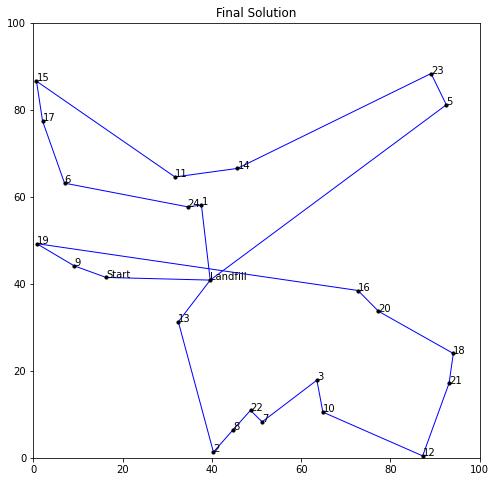

In [53]:
# Final result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k%SALESMEN], linewidth=1)
            
plt.title('Final Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


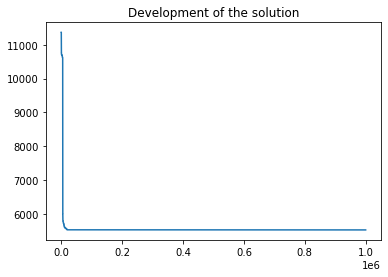

In [54]:
plt.plot(history)
plt.title('Development of the solution')
plt.show()


### Further analysis

In [58]:
res

[[4, 9, 19, 16, 20, 18, 21, 12, 10, 3, 7, 22, 8, 2, 13, 25],
 [25, 25],
 [25, 5, 23, 14, 11, 15, 17, 6, 24, 1, 25],
 [25, 4]]

In [18]:
# Locations that are not part of the solution
used_locations = []

for i in range(len(res)):
    for k in range(len(locations)):
        if locations[k] in res[i]:
            used_locations.append(locations[k])

unused_locations = [x for x in locations if x not in used_locations]


In [19]:
# High priority locations not in solution
for i in range(len(unused_locations)):
    for j in range(df.shape[0]):
        if df.iloc[j]['NAME'] == unused_locations[i] and df.iloc[j]['PRIORITY'] == 5:
            print(unused_locations[i])
            